<a href="https://colab.research.google.com/github/Android998/TensorFlow2.3/blob/master/TFG6.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Paso 1: Importar las librerias**

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## **Paso 2:Pre procesado de datos**

In [2]:
drive.mount("/content/drive")
base_dir = "./drive/My Drive/object_photos2.0"

Mounted at /content/drive


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)


In [4]:
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

print(len(train_generator))

Found 12801 images belonging to 40 classes.
1601


In [5]:
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')
print(len(val_generator))

Found 3200 images belonging to 40 classes.
400


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((8, 224, 224, 3), (8, 40))

### **Generamos el archivo labels con las etiquetas de los objetos**

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'backpack': 0, 'bed': 1, 'belt': 2, 'blind stick': 3, 'bottle': 4, 'carpet': 5, 'cellular phone': 6, 'chair': 7, 'cup-glass': 8, 'door': 9, 'eyeglasses': 10, 'fan': 11, 'handkerchief': 12, 'headphones': 13, 'keys': 14, 'laptop': 15, 'mouse': 16, 'newspaper': 17, 'notebook': 18, 'pen': 19, 'pencil': 20, 'pillow': 21, 'plate': 22, 'plug': 23, 'printer': 24, 'radiator': 25, 'remote control': 26, 'shoes': 27, 'shorts': 28, 'socks': 29, 't-shirts': 30, 'table': 31, 'television': 32, 'toothbrush': 33, 'towel': 34, 'trash bin': 35, 'wallet': 36, 'wardrobe': 37, 'watch': 38, 'window (shade)': 39}


## **Paso 3: Crear el modelo base ya entrenado**

In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

19996672/19993432 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

### **Añadir ultima capa**

In [10]:
base_model.trainable = False

In [11]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(40, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          304160    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                1320      
Total params: 4,575,196
Trainable params: 305,480
Non-trainable params: 4,269,716
_________________________________________________________________


### **Compilar y entrenar el modelo**

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 10, mode = "auto",
    restore_best_weights = True
)

In [15]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=1000,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/1000
1601/1601 [==============================] - 4548s 3s/step - loss: 1.6462 - accuracy: 0.5690 - val_loss: 1.2137 - val_accuracy: 0.6753
Epoch 2/1000
1601/1601 [==============================] - 89s 56ms/step - loss: 1.0006 - accuracy: 0.7202 - val_loss: 1.0299 - val_accuracy: 0.7250
Epoch 3/1000
1601/1601 [==============================] - 88s 55ms/step - loss: 0.8170 - accuracy: 0.7651 - val_loss: 1.0672 - val_accuracy: 0.7106
Epoch 4/1000
1601/1601 [==============================] - 88s 55ms/step - loss: 0.7009 - accuracy: 0.7962 - val_loss: 1.0106 - val_accuracy: 0.7350
Epoch 5/1000
1601/1601 [==============================] - 88s 55ms/step - loss: 0.6134 - accuracy: 0.8185 - val_loss: 1.0254 - val_accuracy: 0.7309
Epoch 6/1000
1601/1601 [==============================] - 89s 55ms/step - loss: 0.5412 - accuracy: 0.8394 - val_loss: 1.0431 - val_accuracy: 0.7303
Epoch 7/1000
1601/1601 [==============================] - 88s 55ms/step - loss: 0.4854 - accuracy: 0.8538 - val_

### **Evaluar el modelo**

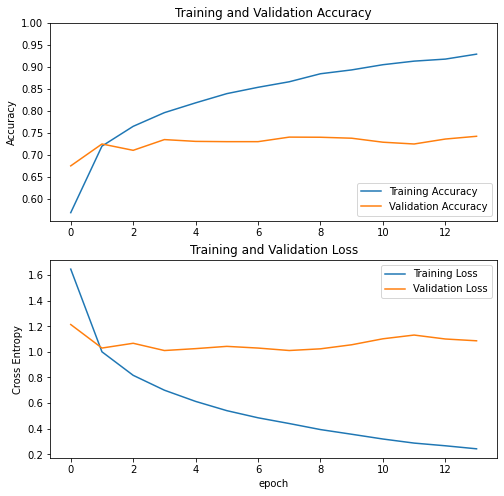

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **Paso 4: Fine Tuning**

In [17]:
base_model.trainable = True

In [18]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 769


In [19]:
fine_tune_at = 400

In [20]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### **Compilar y entrenar el modelo**

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=1000,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/1000
1601/1601 [==============================] - 124s 78ms/step - loss: 1.0448 - accuracy: 0.7037 - val_loss: 1.0818 - val_accuracy: 0.7159
Epoch 2/1000
1601/1601 [==============================] - 122s 76ms/step - loss: 0.5518 - accuracy: 0.8379 - val_loss: 0.9305 - val_accuracy: 0.7750
Epoch 3/1000
1601/1601 [==============================] - 122s 76ms/step - loss: 0.3380 - accuracy: 0.8988 - val_loss: 0.8892 - val_accuracy: 0.7937
Epoch 4/1000
1601/1601 [==============================] - 121s 76ms/step - loss: 0.2411 - accuracy: 0.9307 - val_loss: 1.1826 - val_accuracy: 0.7622
Epoch 5/1000
1601/1601 [==============================] - 121s 76ms/step - loss: 0.1841 - accuracy: 0.9438 - val_loss: 1.0371 - val_accuracy: 0.7881
Epoch 6/1000
1601/1601 [==============================] - 121s 75ms/step - loss: 0.1502 - accuracy: 0.9544 - val_loss: 1.1702 - val_accuracy: 0.7734
Epoch 7/1000
1601/1601 [==============================] - 120s 75ms/step - loss: 0.1363 - accuracy: 0.9588

### **Evaluacion de resultados**

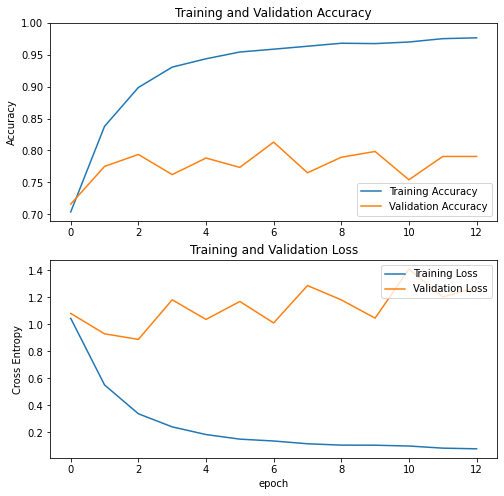

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Seguimos entrenando ya que aun hay margen de mejora**

In [24]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000001), loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=1000,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/1000
1601/1601 [==============================] - 165s 103ms/step - loss: 0.4256 - accuracy: 0.8733 - val_loss: 0.7442 - val_accuracy: 0.8184
Epoch 2/1000
1601/1601 [==============================] - 163s 102ms/step - loss: 0.3588 - accuracy: 0.8928 - val_loss: 0.7141 - val_accuracy: 0.8269
Epoch 3/1000
1601/1601 [==============================] - 161s 101ms/step - loss: 0.3276 - accuracy: 0.9040 - val_loss: 0.7144 - val_accuracy: 0.8259
Epoch 4/1000
1601/1601 [==============================] - 161s 101ms/step - loss: 0.3031 - accuracy: 0.9096 - val_loss: 0.7136 - val_accuracy: 0.8225
Epoch 5/1000
1601/1601 [==============================] - 162s 101ms/step - loss: 0.2849 - accuracy: 0.9127 - val_loss: 0.7105 - val_accuracy: 0.8250
Epoch 6/1000
1601/1601 [==============================] - 162s 101ms/step - loss: 0.2557 - accuracy: 0.9238 - val_loss: 0.7081 - val_accuracy: 0.8253
Epoch 7/1000
1601/1601 [==============================] - 163s 102ms/step - loss: 0.2449 - accuracy:

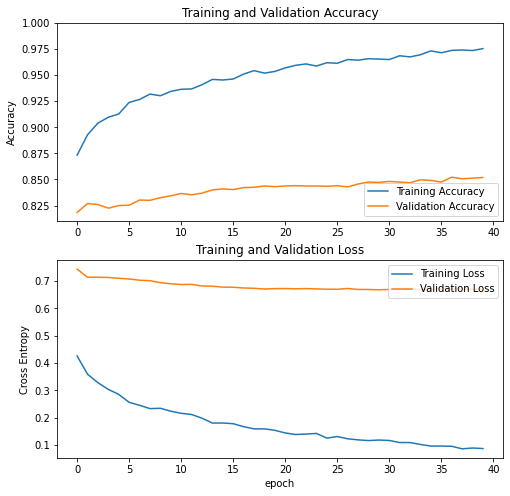

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True
fine_tune_at = 0
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0000001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=1000,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/1000
1601/1601 [==============================] - 238s 149ms/step - loss: 0.1636 - accuracy: 0.9510 - val_loss: 0.6596 - val_accuracy: 0.8525
Epoch 2/1000
1601/1601 [==============================] - 237s 148ms/step - loss: 0.1684 - accuracy: 0.9493 - val_loss: 0.6593 - val_accuracy: 0.8459
Epoch 3/1000
1601/1601 [==============================] - 235s 147ms/step - loss: 0.1649 - accuracy: 0.9494 - val_loss: 0.6608 - val_accuracy: 0.8475
Epoch 4/1000
1601/1601 [==============================] - 235s 147ms/step - loss: 0.1623 - accuracy: 0.9495 - val_loss: 0.6629 - val_accuracy: 0.8484
Epoch 5/1000
1601/1601 [==============================] - 235s 147ms/step - loss: 0.1602 - accuracy: 0.9525 - val_loss: 0.6668 - val_accuracy: 0.8472
Epoch 6/1000
1601/1601 [==============================] - 233s 146ms/step - loss: 0.1646 - accuracy: 0.9497 - val_loss: 0.6722 - val_accuracy: 0.8475
Epoch 7/1000
1601/1601 [==============================] - 231s 144ms/step - loss: 0.1611 - accuracy:

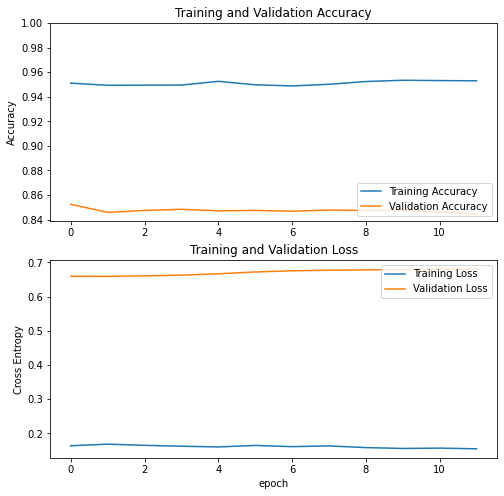

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Cargar el modelo de TFLite**

In [32]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [33]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>